# LIME

In [ ]:
### 이미지 다운로드
!wget https://pics.craiyon.com/2023-06-02/c5a9d304affd44dab91a4160224b52f8.webp -O image2.jpg 

In [ ]:
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
image_path = "/kaggle/working/image2.jpg"
image = Image.open(image_path)
image

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

model = models.resnet50(pretrained=True).eval().to(device)

In [ ]:
# 이미지 -> 텐서 변환 과정
input_tensor = test_transform(image).unsqueeze(0).to(device)
input_tensor.shape

In [ ]:
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    pred = torch.nn.functional.softmax(output, dim=1)

# 가장 높은 확률을 가진 상위 5개의 클래스와 그 확률
top5_probabilities, top5_classes = torch.topk(probabilities, 5)
print(top5_probabilities, top5_classes)

In [ ]:
# 이미지넷 클래스 인덱스와 비교하기 위하여 클래스 이름 목록 다운로드
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt -O imagenet_labels.txt

In [ ]:
label_txt_path = "/kaggle/working/imagenet_labels.txt"
imagenet_labels = [line.strip() for line in open(label_txt_path)]

In [ ]:
# 레이블 딕셔너리 변환
imagenet_labels_dict = {}
for item in imagenet_labels:
    if isinstance(item, str):
        key, value = item.split(':', 1)
        key = int(key.strip('{}'))
        value = value.strip(" ,'")
        imagenet_labels_dict[key] = value

In [ ]:
for i in range(10):
    print(i, imagenet_labels_dict[i])

In [ ]:
# 상위 5개 확률과 그 레이블 확인
top5_labels = [imagenet_labels_dict[i] for i in top5_classes.cpu().numpy()]
for i in range(5):
    print(top5_probabilities.cpu().numpy()[i], top5_labels[i])

In [ ]:
# 예측 함수 정의
def predict(image, model=model):
    model.eval()
    
    # numpy.ndarray를 PyTorch 텐서로 변환하고 차원 조정
    if isinstance(image, np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
        image = image.permute(0, 3, 1, 2)  # (batch, height, width, channels) -> (batch, channels, height, width)
    
    image = image.to(device)
    logits = model(image)
    pred = torch.nn.functional.softmax(logits, dim=1)
    
    return pred.detach().cpu().numpy()

In [ ]:
# input_tensor를 numpy 배열로 변환 (H, W, C 형식)
image_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()


## LIME Image Explainer을 통한 이미지 설명

In [ ]:
from lime import lime_image

# 이미지 설명자를 초기화 및 인스턴스 생성
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(image_np,      # 이미지 행렬
                                         predict,       # 예측 함수, 입력 이미지에 대한 확률 벡터를 반환
                                         top_labels=5,  # 설명할 최상위 레이블의 수
                                         hide_color=0,  # 설명 생성 시 특정 클래스를 가릴 때 사용할 색상
                                         num_samples=1000,  # 주변 환경을 생성하기 위해 사용할 샘플의 수, ImageNet 기준 1000개 클래스
                                         batch_size=100)

In [ ]:
from skimage.segmentation import mark_boundaries

plt.figure(figsize=(30, 30))
for i in range(1, 6):
    # LIME에서 이미지와 마스크 가져오기
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i-1], 
                                                positive_only=True, 
                                                num_features=5, 
                                                hide_rest=True)
    
    # 경계 표시
    image_boundary = mark_boundaries(temp, mask)
    # 서브플롯에 이미지 표시
    plt.subplot(6, 1, i)
    plt.imshow(image_boundary)
    
    # 텍스트와 확률을 이미지 상단에 표시
    plt.text(0, 0, f"{top5_labels[i-1]}: {top5_probabilities[i-1]:.4f}", fontsize=20, color='white', bbox=dict(facecolor='black', alpha=0.5))
    
    plt.axis('off')

plt.show()

# Grad-CAM

In [1]:
!pip install grad-cam torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=6c10b7b094d595997f44f1fbc46f985163f9e65815a58e3396505608fe261cc1
  Stored in directory: /Users/vin_ah/Library/Caches/pip/wheels/93/dd/8d/d4bb2adf5bba55336ae8c60a2f24c2a3f2fb73e03d5da52363
Successfully built grad-cam


In [2]:
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F

In [3]:
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image, show_factorization_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [4]:
# 이미지 다운로드
!wget https://upload.wikimedia.org/wikipedia/commons/8/8c/Persian_silver_dollface.jpg -O image.jpg

--2024-09-09 11:47:50--  https://upload.wikimedia.org/wikipedia/commons/8/8c/Persian_silver_dollface.jpg
upload.wikimedia.org (upload.wikimedia.org) 해석 중... 103.102.166.240
다음으로 연결 중: upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 75639 (74K) [image/jpeg]
저장 위치: `image.jpg'

image.jpg           100%[===================>]  73.87K   330KB/s    /  0.2s    

2024-09-09 11:47:51 (330 KB/s) - `image.jpg' 저장함 [75639/75639]



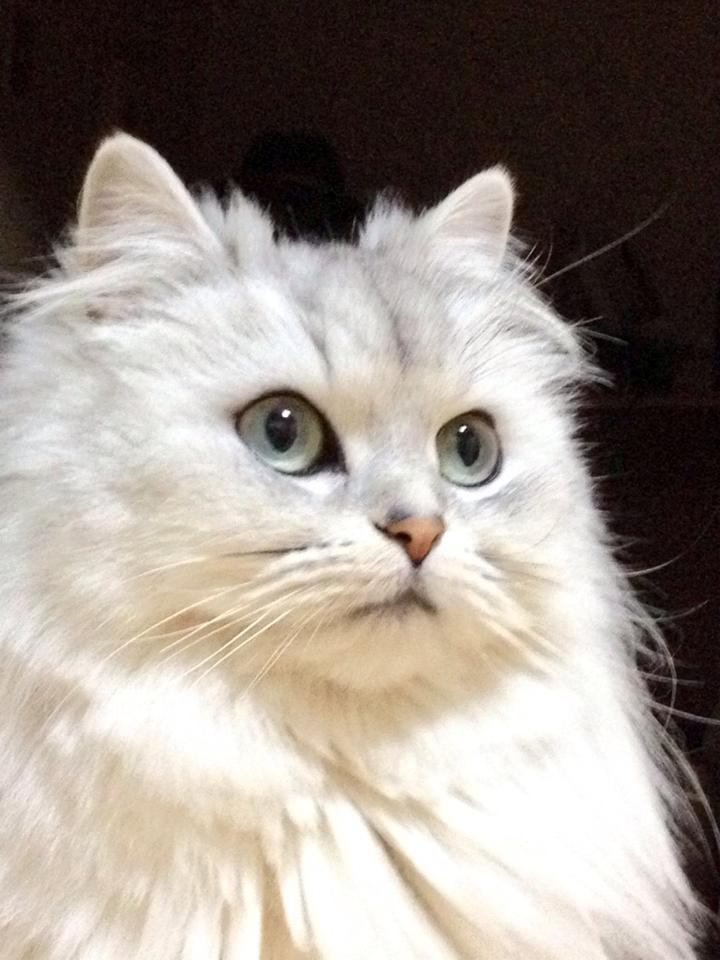

In [6]:
img_path = "./image.jpg"
img_pil = Image.open(img_path)
img_pil

In [7]:
# 이미지 변환 및 모델 불러오기
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

model = models.resnet50(pretrained=True).eval().to(device)

/Users/vin_ah/miniconda3/envs/module0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vin_ah/miniconda3/envs/module0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/vin_ah/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.6MB/s]


In [17]:
# 이미지 변환
input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

# Class를 Activation 할 레이어 선정. 여기에선 ResNet50의 마지막 feature map
target_layers = [model.layer4[-1]]

# ImageNet 기준 283번 클래스에 대한 시각화 활성화
targets = [ClassifierOutputTarget(283)] 

NameError: name 'label' is not defined

In [16]:
targets

In [15]:
target_layers

[Bottleneck(
   (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
 )]

In [10]:
# 다양한 Grad-CAM을 활용한 모델 설명
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, LayerCAM

grad_cam = GradCAM(model=model, target_layers=target_layers)
grad_cam_map = grad_cam(input_tensor=input_tensor, targets=targets)[0]

grad_cam_plus_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)
grad_cam_plus_plus_map = grad_cam_plus_plus(input_tensor=input_tensor, targets=targets)[0]

x_grad_cam = XGradCAM(model=model, target_layers=target_layers)
x_grad_cam_map = x_grad_cam(input_tensor=input_tensor, targets=targets)[0]

layer_cam = LayerCAM(model=model, target_layers=target_layers)
layer_cam_map = layer_cam(input_tensor=input_tensor, targets=targets)[0]

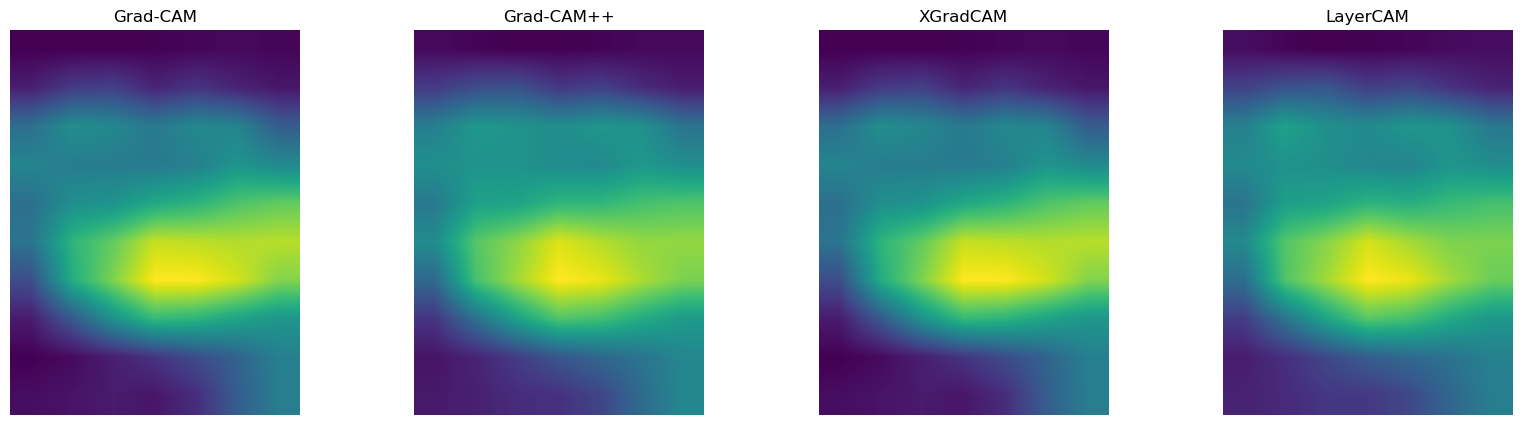

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# GradCAM
axs[0].imshow(grad_cam_map)
axs[0].title.set_text('Grad-CAM')
axs[0].axis('off')

# GradCAMPlusPlus
axs[1].imshow(grad_cam_plus_plus_map)
axs[1].title.set_text('Grad-CAM++')
axs[1].axis('off')

# XGradCAM
axs[2].imshow(x_grad_cam_map)
axs[2].title.set_text('XGradCAM')
axs[2].axis('off')

# LayerCAM
axs[3].imshow(layer_cam_map)
axs[3].title.set_text('LayerCAM')
axs[3].axis('off')

plt.show()

In [12]:
import torchcam
from torchcam.utils import overlay_mask

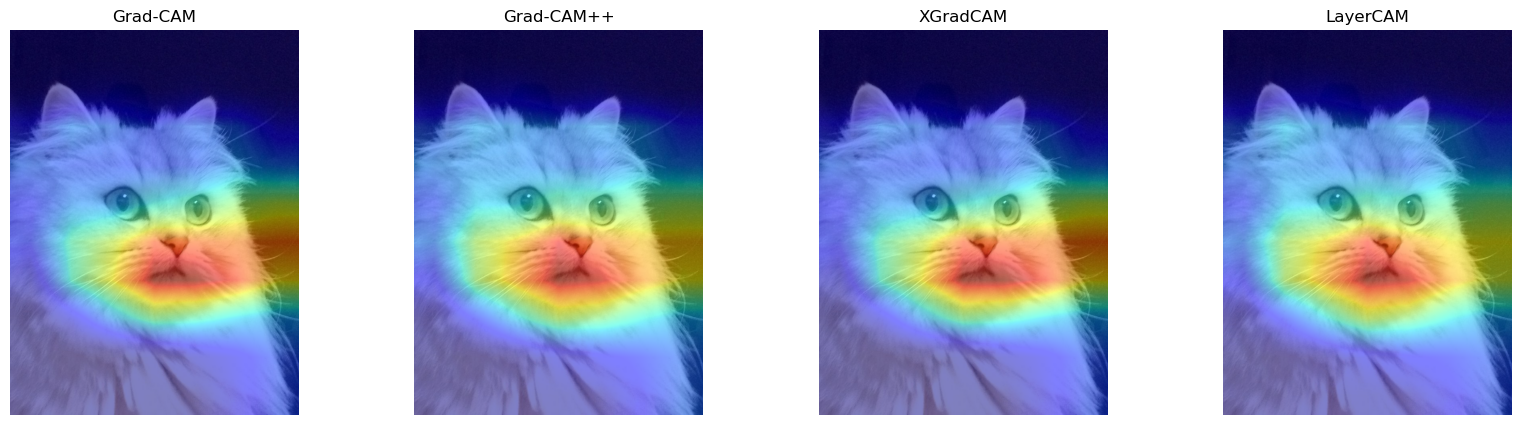

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# GradCAM
grad_cam_overlay = overlay_mask(img_pil, Image.fromarray(grad_cam_map), alpha=0.5)
axs[0].imshow(grad_cam_overlay)
axs[0].title.set_text('Grad-CAM')
axs[0].axis('off')

# GradCAMPlusPlus
grad_cam_plus_plus_overlay = overlay_mask(img_pil, Image.fromarray(grad_cam_plus_plus_map), alpha=0.5)
axs[1].imshow(grad_cam_plus_plus_overlay)
axs[1].title.set_text('Grad-CAM++')
axs[1].axis('off')

# XGradCAM
x_grad_cam_overlay = overlay_mask(img_pil, Image.fromarray(x_grad_cam_map), alpha=0.5)
axs[2].imshow(x_grad_cam_overlay)
axs[2].title.set_text('XGradCAM')
axs[2].axis('off')

# LayerCAM
layer_cam_overlay = overlay_mask(img_pil, Image.fromarray(layer_cam_map), alpha=0.5)
axs[3].imshow(layer_cam_overlay)
axs[3].title.set_text('LayerCAM')
axs[3].axis('off')

plt.show()